In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import rich

from touch_rugby_analyzer.constants import ASSETS_ROOT, ROOT, DATA_ROOT

def time_to_n_seconds(time_obj):
    return 3600*time_obj.hour + 60*time_obj.minute + time_obj.second

LOCAL_TEAM_NAME = "France"
OTHER_TEAM_NAME = "Ned"

In [4]:
data_path = DATA_ROOT / "test_data_v2.csv"
output_data_root = DATA_ROOT / "output"
output_data_root.mkdir(parents=True, exist_ok=True)
data_df = pd.read_csv(data_path)

data_df = data_df.dropna(axis=0, how="all",subset="Time")
# data_df.Time = pd.to_datetime(data_df.Time).dt.time
data_df.Time = pd.to_datetime(data_df.Time)
data_df["Team"] = data_df.apply(lambda row: LOCAL_TEAM_NAME if ((row["Against France"] and row["Type"] in ["Penalty","Turnover"]) or (not row["Against France"]and row["Type"] not in ["Penalty","Turnover"])) else OTHER_TEAM_NAME, axis=1)
data_df["TeamOld"] = data_df["Against France"].apply(lambda x: OTHER_TEAM_NAME if x else LOCAL_TEAM_NAME)

def add_team_after(data_df: pd.DataFrame):
    ball_owners = []
    for i, row in data_df.iterrows():
        against_local = row["Against France"]
        if i==0:
            new_expected_ball_owner = OTHER_TEAM_NAME if against_local else LOCAL_TEAM_NAME
        else:
            if row["Type"]=="Try":
                assert ((against_local and ball_owners[-1]==OTHER_TEAM_NAME) or (not against_local and ball_owners[-1]==LOCAL_TEAM_NAME))
                new_expected_ball_owner = LOCAL_TEAM_NAME if against_local else OTHER_TEAM_NAME
            elif row["Type"] in ["Penalty", "Turnover"] and ((against_local and ball_owners[-1]==LOCAL_TEAM_NAME) or (not against_local and ball_owners[-1]==OTHER_TEAM_NAME)):
                new_expected_ball_owner = OTHER_TEAM_NAME if against_local else LOCAL_TEAM_NAME    
            elif row["Type"] in ["Game Event"]:
                new_expected_ball_owner = OTHER_TEAM_NAME if against_local else LOCAL_TEAM_NAME
            else:
                new_expected_ball_owner = ball_owners[-1]
        ball_owners.append(new_expected_ball_owner)
    data_df["ball_owner"] = ball_owners
add_team_after(data_df)
data_df

C:\Users\robin\AppData\Local\Temp\ipykernel_20324\947059180.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df.Time = pd.to_datetime(data_df.Time)


,Time,Type,Name,Against France,To Review,Comment,Youtube Link,Team,TeamOld,ball_owner
0,2025-09-14 00:02:14,Game Event,Game Start,True,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,Ned,Ned,Ned
1,2025-09-14 00:02:45,Try,Try,True,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,Ned,Ned,France
2,2025-09-14 00:03:54,Turnover,6th Touch,True,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,France,Ned,Ned
3,2025-09-14 00:04:27,Turnover,Ball Down,False,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,Ned,France,France
4,2025-09-14 00:04:46,Turnover,6th Touch,True,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,France,Ned,Ned
...,...,...,...,...,...,...,...,...,...,...
72,2025-09-14 00:45:35,Turnover,Ball Down,False,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,Ned,France,France
73,2025-09-14 00:46:08,Try,Try,False,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,France,France,Ned
74,2025-09-14 00:46:35,To Review,Other,False,True,Seems like the same as the shoulder against Fr...,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,France,France,Ned
75,2025-09-14 00:46:58,Turnover,6th Touch,False,False,NaN,https://youtu.be/OVdyq3oRq_w?si=UqAu1x62-mD_XZ...,Ned,France,France


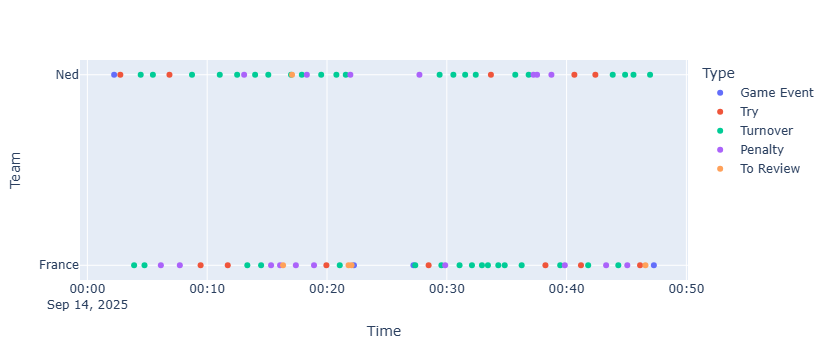

In [5]:
fig = px.scatter(
    data_df, 
    x='Time', 
    y='Team',
    hover_name="Name",
    hover_data="Comment",
    color="Type",
    category_orders={"Team": [OTHER_TEAM_NAME, "France"]}
)
fig.write_html(output_data_root / "recap.html")
fig.show()

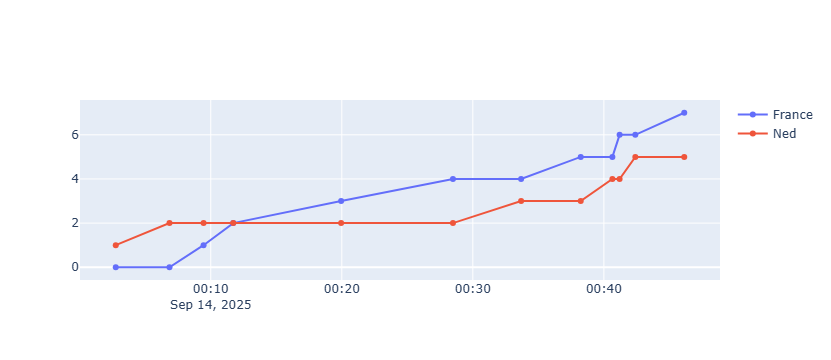

In [6]:
score_data = []
score_local = 0
score_other = 0
for i, row in data_df[data_df["Type"]=="Try"].iterrows():
    if row["Against France"]:
        score_other += 1
    else:
        score_local += 1
    score_data.append([
        row["Time"],
        score_local,
        score_other]
    )
score_df = pd.DataFrame(score_data, columns=["Time", f"Score {LOCAL_TEAM_NAME}", f"Score {OTHER_TEAM_NAME}"])


fig = go.Figure()
fig.add_scatter(x=score_df["Time"], y=score_df[f"Score {LOCAL_TEAM_NAME}"], name=LOCAL_TEAM_NAME, mode='markers+lines')
fig.add_scatter(x=score_df["Time"], y=score_df[f"Score {OTHER_TEAM_NAME}"], name=OTHER_TEAM_NAME, mode='markers+lines')
fig.update_layout(hovermode="x unified")
fig.write_html(output_data_root / "score.html")
fig.show()

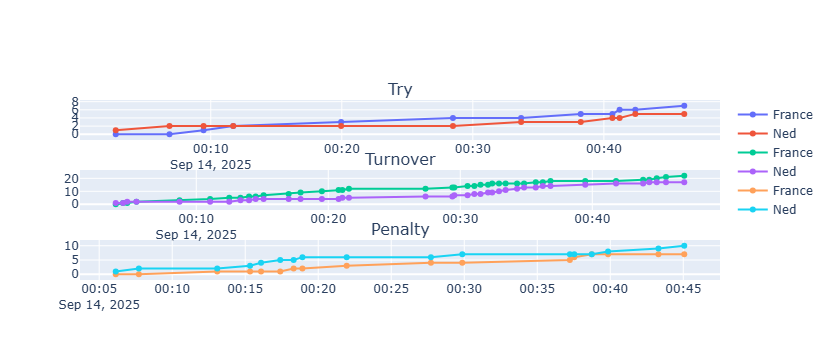

In [7]:
events = ["Try", "Turnover", "Penalty"]
fig = make_subplots(len(events),1, subplot_titles=events)
for i, event_name in enumerate(events):
    event_data = []
    event_local, event_other = 0, 0
    for j, row in data_df[data_df["Type"]==event_name].iterrows():
        if row["Against France"]:
            event_other += 1
        else:
            event_local += 1
        event_data.append([
            row["Time"],
            event_local,
            event_other]
        )
    event_df = pd.DataFrame(event_data, columns=["Time", f"{event_name} {LOCAL_TEAM_NAME}", f"{event_name} {OTHER_TEAM_NAME}"])

    fig.add_trace(go.Scatter(
        x=event_df["Time"], y=event_df[f"{event_name} {LOCAL_TEAM_NAME}"], name=LOCAL_TEAM_NAME, mode='markers+lines'
    ), i+1, 1)
    fig.add_trace(go.Scatter(x=event_df["Time"], y=event_df[f"{event_name} {OTHER_TEAM_NAME}"], name=OTHER_TEAM_NAME, mode='markers+lines'), i+1, 1)
fig.update_layout(hovermode="x unified")
fig.write_html(output_data_root / "events.html")
fig.show()

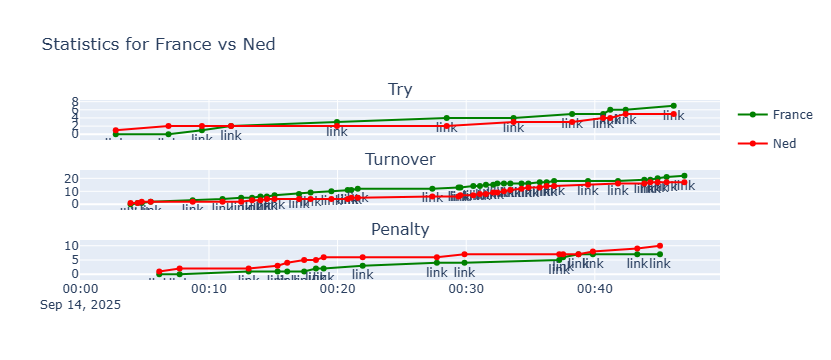

35.786s (28 possessions)

45.258s (31 possessions)

In [12]:
events = ["Try", "Turnover", "Penalty"]
trend_fig = make_subplots(len(events),1, subplot_titles=events, shared_xaxes=True)

for i, event_name in enumerate(events):
    event_data = []
    event_local, event_other = 0, 0
    for j, row in data_df[data_df["Type"]==event_name].iterrows():
        if row["Against France"]:
            event_other += 1
        else:
            event_local += 1
        event_data.append([
            row["Time"],
            event_local,
            event_other,
            row['Youtube Link'],
        ]
        )
    event_df = pd.DataFrame(event_data, columns=["Time", f"{event_name} {LOCAL_TEAM_NAME}", f"{event_name} {OTHER_TEAM_NAME}", "Link"])

    trend_fig.add_trace(go.Scatter(
        x=event_df["Time"], 
        y=event_df[f"{event_name} {LOCAL_TEAM_NAME}"], 
        name=LOCAL_TEAM_NAME, 
        mode='markers+lines+text', 
        marker_color="green",
        legendgroup=LOCAL_TEAM_NAME,
        showlegend=i==0,
        text=[f"<a href='{row['Link']}'>link</a>" for i, row in event_df.iterrows()],
        textposition="bottom center"
    ), i+1, 1)
    trend_fig.add_trace(go.Scatter(
        x=event_df["Time"], 
        y=event_df[f"{event_name} {OTHER_TEAM_NAME}"], 
        name=OTHER_TEAM_NAME, 
        mode='markers+lines', 
        marker_color="red",
        legendgroup=OTHER_TEAM_NAME,
        showlegend=i==0,
    ), i+1, 1)

    
score_data = []
against_local, prev_time = None, None
local_possesion_ts, other_possesion_ts = [], []
for i, row in data_df.iterrows():
    # rich.print(f"{row['Type']}-{row['Name']} (Against Local={row['Against France']})")
    
    if row["Type"]=="Game Event" and row["Name"] == "Game Start":
        prev_time = None
        
    if prev_time is None:
        prev_time = row["Time"]
        against_local = row["Against France"]
        ball_owner = OTHER_TEAM_NAME if against_local else LOCAL_TEAM_NAME
        points_x = [prev_time]
        points_y = [ball_owner]
        hovertext = [f"{row['Type']}-{row['Name']}"]
    else:
        new_time = row["Time"]
        against_local = row["Against France"]

        points_x.append(new_time)
        points_y.append(ball_owner)
        hovertext.append(f"{row['Type']}-{row['Name']}")
        
        if row["Type"]=="Try":
            assert ((against_local and ball_owner==OTHER_TEAM_NAME) or (not against_local and ball_owner==LOCAL_TEAM_NAME))
            update_plot = True
            new_expected_ball_owner = LOCAL_TEAM_NAME if against_local else OTHER_TEAM_NAME
        elif row["Type"] in ["Penalty", "Turnover"] and ((against_local and ball_owner==LOCAL_TEAM_NAME) or (not against_local and ball_owner==OTHER_TEAM_NAME)):
            update_plot = True
            new_expected_ball_owner = OTHER_TEAM_NAME if against_local else LOCAL_TEAM_NAME    
        elif row["Type"] in ["Game Event"]:
            update_plot = True
            new_expected_ball_owner = OTHER_TEAM_NAME if against_local else LOCAL_TEAM_NAME
        else:
            update_plot = False
            new_expected_ball_owner = ball_owner

        if update_plot:
            possession_duration = time_to_n_seconds(points_x[-1]) - time_to_n_seconds(points_x[0])
            if new_expected_ball_owner == OTHER_TEAM_NAME:
                local_possesion_ts.append(possession_duration)
            else:
                other_possesion_ts.append(possession_duration)
            prev_time = new_time
            
            points_x = [prev_time]
            points_y = [new_expected_ball_owner]
            hovertext = [f""]
            ball_owner = new_expected_ball_owner

trend_fig.update_layout(hovermode="x unified", title=f"Statistics for {LOCAL_TEAM_NAME} vs {OTHER_TEAM_NAME}")
trend_fig.write_html(output_data_root / "events.html")
trend_fig.show()

rich.print(f"{np.mean(local_possesion_ts):.3f}s ({len(local_possesion_ts)} possessions)")
rich.print(f"{np.mean(other_possesion_ts):.3f}s ({len(other_possesion_ts)} possessions)")


In [13]:
_data_df = data_df[[
    "Type",
    "Name",
    "Team",
]][data_df.Type.isin(["Penalty", "Turnover"])]
output = _data_df.groupby([ "Type","Team", "Name"]).size()
output.to_csv(output_data_root / "stats.csv", index=True)

penalty_types = list(_data_df[_data_df["Type"]=="Penalty"]["Name"].unique())
turnover_types = list(_data_df[_data_df["Type"]=="Turnover"]["Name"].unique())
column_names = penalty_types + turnover_types

new_stats_df = pd.DataFrame(np.zeros((2, len(column_names)), dtype=int), index=[LOCAL_TEAM_NAME, OTHER_TEAM_NAME], columns=column_names)
for i, row in _data_df.iterrows():
    new_stats_df.loc[row["Team"],row["Name"]]+=1
    
new_stats_df["Average Possession Time"] = [np.mean(local_possesion_ts).round(3), np.mean(other_possesion_ts).round(3)]
rich.print(f"{np.mean(local_possesion_ts):.3f}s ({len(local_possesion_ts)} possessions)")
rich.print(f"{np.mean(other_possesion_ts):.3f}s ({len(other_possesion_ts)} possessions)")
# output
new_stats_df.to_csv(output_data_root / "stats_v2.csv", index=True)
new_stats_df

35.786s (28 possessions)

45.258s (31 possessions)

,Touch and Pass,Forward Pass,Offside,Delay of Play,Hard Touch,In The Ruck,Shoulder,6th Touch,Ball Down,Dummy Touch,Interception,6 Again,Average Possession Time
France,1,4,1,1,0,2,1,4,9,1,0,3,35.786
Ned,0,3,2,0,2,0,0,10,11,0,1,0,45.258


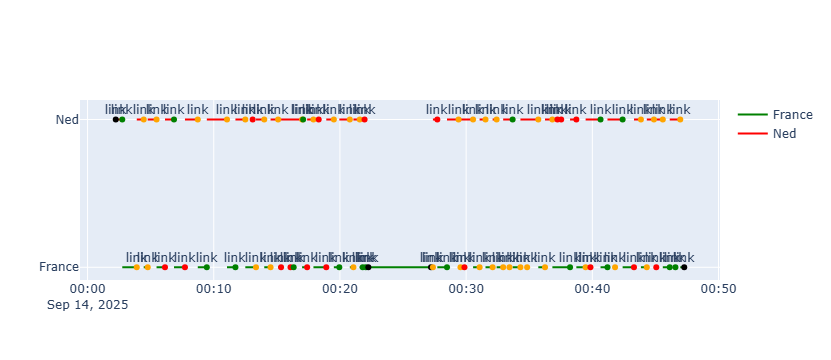

In [14]:
game_fig = go.Figure()
score_data = []
against_local, prev_time = None, None

for n, colour in [(LOCAL_TEAM_NAME, "green"), (OTHER_TEAM_NAME, "red")]:
    points_x, points_y = [], []
    for i, row in data_df.iterrows():
        if row["ball_owner"] == n:
            points_x.append(row["Time"])
            points_y.append(n)
        else:
            if i>0 and data_df.iloc[i-1]["ball_owner"] == n:
                points_x.append(row["Time"])
                points_y.append(n)
                points_x.append(None)
                points_y.append(None)
            else:
                continue
    game_fig.add_trace(
        go.Scatter(
            x=points_x, 
            y=points_y, 
            mode='lines',
            hoverinfo=None,
            marker_color=colour,
            name=n
        )
    )

annotations = []
for i, row in data_df.iterrows():
    # rich.print(f"{row['Type']}-{row['Name']} (Against Local={row['Against France']})")
    
    if row["Type"]=="Penalty":
        color = "red"
    elif row["Type"]=="Turnover":
        color = "orange"
    elif row["Type"]=="Game Event":
        color = "black"
    else:
        color = "green"
    hovertext = f"{row['Type']}-{row['Name']}"
    game_fig.add_trace(go.Scatter(
        x=[row["Time"]], 
        y=[row["Team"]], 
        mode='markers',
        # name=hovertext,
        hovertext=hovertext,
        marker_color=color,
        showlegend=False,
    ))
    annotations.append(
            dict(
                x=row["Time"],
                y=row["Team"],
                text=f"<a href='{row['Youtube Link']}'>link</a>",
                showarrow=False,
                yshift=10,
            ))
    
game_fig.update_layout(annotations=annotations)
# fig.update_layout(hovermode="x unified", annotations)
game_fig.write_html(output_data_root / "events_v2.html")
game_fig.show()

In [18]:
from jinja2 import Template

input_template_path=ASSETS_ROOT / "template.html"
output_html_path=ROOT / "index.html"

plotly_jinja_data = {
    "game_fig":    game_fig.to_html(full_html=False),
    "trend_fig":   trend_fig.to_html(full_html=False),
    "stats_table": new_stats_df.to_html(),
}
#consider also defining the include_plotlyjs parameter to point to an external Plotly.js as described above

with output_html_path.open("w", encoding="utf-8") as output_file:
    with input_template_path.open() as template_file:
        j2_template = Template(template_file.read())
        output_file.write(j2_template.render(plotly_jinja_data))